In [15]:
import ROOT
import time
import struct
import math
import numpy as np

def double_to_hex(f):
    return hex(struct.unpack('<Q', struct.pack('<d', f))[0])

def float_to_hex(f):
    return hex(struct.unpack('<I', struct.pack('<f', f))[0])

def digi(value, nbit, varmin, varmax):
    output = int(round((value-varmin)*2**nbit/(varmax-varmin)))
    if (output>>nbit) > 0:
      output = int(round(varmax))-1
      print("[WARNING] Digi conversion overflow")
    return output

def eta2rz(eta):
    return math.tan(2*math.atan(math.exp(-eta)))

def calc_percentile(arra, init_step = 5):

    #from https://stats.stackexchange.com/questions/103258/online-estimation-of-quartiles-without-storing-observations
    M = Q1 = Q3 = arra[0]
    step =step_Q1 = step_Q3 = init_step
    

    import random
    #random.shuffle(a)


    #print("actual mean = ",np.mean(arra))
    #print("actual 25% percetile = ",np.percentile(arra,25))
    #print("actual 75% percetile = ",np.percentile(arra,75))

    for data in arra[1:] :
            # update median M 
            if M > data:
                M = M - step
            elif M < data:
                M = M + step
            if abs(data-M) < step:
                step = step /2

            # estimate Q1 using M
            if data < M:
                if Q1 > data:
                    Q1 = Q1 - step_Q1
                elif Q1 < data:
                    Q1 = Q1 + step_Q1
                if abs(data - Q1) < step_Q1:
                    step_Q1 = step_Q1/2
            # estimate Q3 using M
            elif data > M:
                if Q3 > data:
                    Q3 = Q3 - step_Q3
                elif Q3 < data:
                    Q3 = Q3 + step_Q3
                if abs(data-Q3) < step_Q3:
                    step_Q3 = step_Q3 /2

    #print("streaming 25% percentile = ",Q1)
    #print("streaming 75% percentile = ",Q3)
    #print("error 25% = ",np.percentile(arra,25)-Q1)
    #print("error 75% = ",np.percentile(arra,75)-Q3)

    return [(np.percentile(arra,25)-Q1)*100/np.percentile(arra,25), (np.percentile(arra,75)-Q3)*100/np.percentile(arra,75)]


f = ROOT.TFile.Open("ntuple_giacomo.root")
f.Print("v")
keys = f.hgcalTriggerNtuplizer.GetListOfKeys()
for key in keys:
  print(key)

tree = f.hgcalTriggerNtuplizer.FindObjectAny("HGCalTriggerNtuple")


tree.Print()

Name: HGCalTriggerNtuple Title: HGCalTriggerNtuple
Name: HGCalTriggerNtuple Title: HGCalTriggerNtuple
TFile: name=ntuple_giacomo.root, title=, option=READ
******************************************************************************
*Tree    :HGCalTriggerNtuple: HGCalTriggerNtuple                                     *
*Entries :      100 : Total =      2899187553 bytes  File  Size =  675743523 *
*        :          : Tree compression factor =   4.29                       *
******************************************************************************
*Br    0 :run       : run/I                                                  *
*Entries :      100 : Total  Size=       2777 bytes  File Size  =       2080 *
*Baskets :       20 : Basket Size=       2558 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :event     : event/I                                                *
*Entries :      100 : Total  Size=       2825 b

Warning in <TFile::Append>: Replacing existing TH1: gamma_clu_energy (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: BG_clu_energy (Potential memory leak).


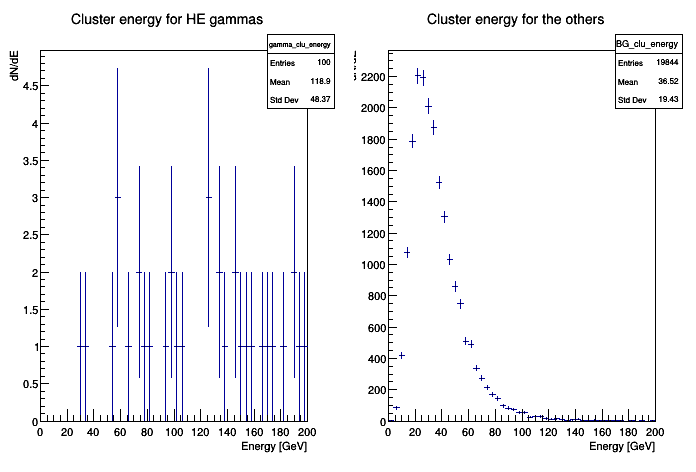

In [69]:
#rzphi_clu= ROOT.TH2F("rzphi_clu","rzphi_clu",50,0.09,0.5,50,-3.14,3.14)

gamma_clu_energy = ROOT.TH1F("gamma_clu_energy","gamma_clu_energy",50,0,200)
BG_clu_energy = ROOT.TH1F("BG_clu_energy","BG_clu_energy",50,0,200)

total_cluster_vect = {}


for event in tree:
  tc_list = {}
  tc_cluster_vect = {}
  cluster_ene = []

  for i in range(event.tc_n):
     tc_list[event.tc_id[i]]=i

  #print("----------------------------")

  for clu_n in range(event.cl3d_n):
    cluster_ene.append(event.cl3d_pt[clu_n])
    vettore_reco = ROOT.TVector3()
    vettore_reco.SetPtEtaPhi(event.cl3d_pt[clu_n],event.cl3d_eta[clu_n],event.cl3d_phi[clu_n])
    tc_cluster_vect[event.cl3d_id[clu_n]]= [vettore_reco]
    tc_energy = []
    for tc_id in event.cl3d_clusters_id[clu_n]:
        i=tc_list[tc_id]
        tc_energy.append(event.tc_energy[i])
        #print("TC E,rz,phi","{:.3f}".format(event.tc_energy[i]),"{:.3f}".format(vettore.XYvector().Mod()/event.tc_z[i]),"{:.3f}".format(event.tc_phi[i]))
    tc_cluster_vect[event.cl3d_id[clu_n]].append(calc_percentile(tc_energy))
    tc_cluster_vect[event.cl3d_id[clu_n]].append(tc_energy)    
    #print(event.cl3d_pt[clu_n],percentiles[0],percentiles[1])
        
  #for vec_id, gen_id in enumerate(event.genpart_gen):
  #  if event.genpart_pid[vec_id]==22 and event.genpart_pt[vec_id]>1:
  #    print(gen_id, event.genpart_pt[vec_id], event.genpart_eta[vec_id], event.genpart_pid[vec_id])
  #    vettore_gen = ROOT.TVector3()
  #    vettore_gen.SetPtEtaPhi(event.genpart_pt[vec_id],event.genpart_eta[vec_id],event.genpart_phi[vec_id])
  #    deltaR_vec=[]
  #    for clu_id in tc_cluster_vect:
  #      deltaR_vec.append(vettore_gen.DeltaR(tc_cluster_vect[clu_id][0]))
  #      if vettore_gen.DeltaR(tc_cluster_vect[clu_id][0])<0.3:
  #          print("DeltaR",vettore_gen.DeltaR(tc_cluster_vect[clu_id][0]))
  #          print(tc_cluster_vect[clu_id][0].Pt(),tc_cluster_vect[clu_id][0].Eta(),tc_cluster_vect[clu_id][0].Phi())
  #          tc_cluster_vect[clu_id].append(event.genpart_pid[vec_id])  
  #    print("Min DeltaR=",min(deltaR_vec))
            
                
  for i in range(event.gen_n):
    if abs(event.gen_eta[i])>1.5 and abs(event.gen_eta[i])<3.0 and event.gen_pdgid[i]==22 and event.gen_pt[i]>10:
      vettore_gen = ROOT.TVector3()
      vettore_gen.SetPtEtaPhi(event.gen_pt[i],event.gen_eta[i],event.gen_phi[i])
      deltaR_vec={}
      #print(event.gen_pdgid[i],event.gen_pt[i],event.gen_eta[i],event.gen_phi[i]) 
      for clu_id in tc_cluster_vect:
        deltaR_vec[vettore_gen.DeltaR(tc_cluster_vect[clu_id][0])]=tc_cluster_vect[clu_id][0].Pt()
        if vettore_gen.DeltaR(tc_cluster_vect[clu_id][0])<0.1:# and event.gen_status[i]==1:
            #print("DeltaR",vettore_gen.DeltaR(tc_cluster_vect[clu_id][0]))
            #print(tc_cluster_vect[clu_id][0].Pt(),tc_cluster_vect[clu_id][0].Eta(),tc_cluster_vect[clu_id][0].Phi())
            tc_cluster_vect[clu_id].append(event.gen_pdgid[i])
            gamma_clu_energy.Fill(tc_cluster_vect[clu_id][0].Mag())
            #print(tc_cluster_vect[clu_id][1])
        else:
            BG_clu_energy.Fill(tc_cluster_vect[clu_id][0].Mag())
      #print("Min DeltaR=",min(deltaR_vec.keys()),deltaR_vec[min(deltaR_vec.keys())])
    
  
  total_cluster_vect = {**total_cluster_vect , **tc_cluster_vect}


canvas = ROOT.TCanvas()
canvas.Divide(2)
canvas.cd(1)
gamma_clu_energy.SetTitle("Cluster energy for HE gammas")
gamma_clu_energy.GetYaxis().SetTitle("dN/dE")
gamma_clu_energy.GetXaxis().SetTitle("Energy [GeV]")
gamma_clu_energy.Draw("ER")
canvas.cd(2)
BG_clu_energy.SetTitle("Cluster energy for the others")
BG_clu_energy.GetYaxis().SetTitle("dN/dE")
BG_clu_energy.GetXaxis().SetTitle("Energy [GeV]")
BG_clu_energy.Draw("ER")

canvas.Draw()

2.0462715247815524 0.2749539911746979 1.249790906906128 0.14058841603755007 0.6774733188294173
0.7862743788031463 0.3249456286430359 0.8420423865318298 0.36588000347879285 1.7631178103883844


Warning in <TFile::Append>: Replacing existing TH1: total_tc_energy_gamma (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: total_tc_energy_nongamma (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: quantile25err (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: quantile25err (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: quantile25errVsN (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: quantile75err (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: quantile75err (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: quantile75errVsN (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas2b
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas3
Warning in <TCanvas::

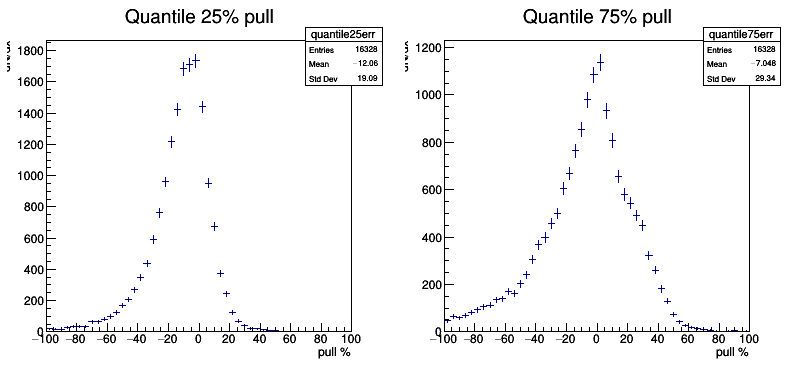

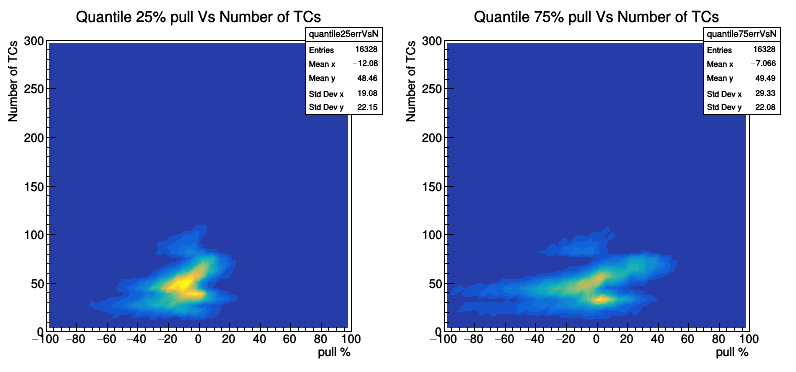

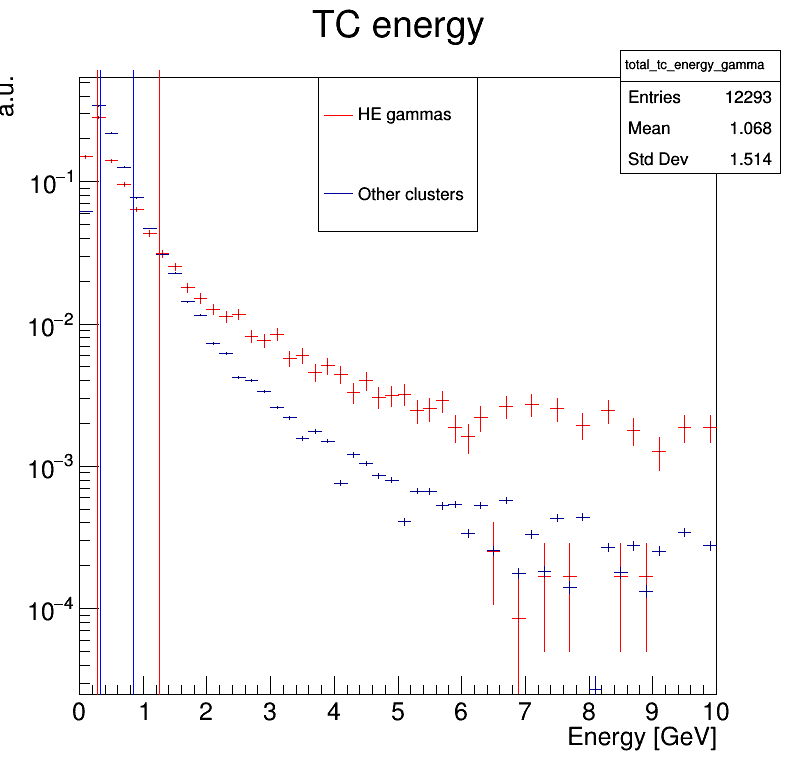

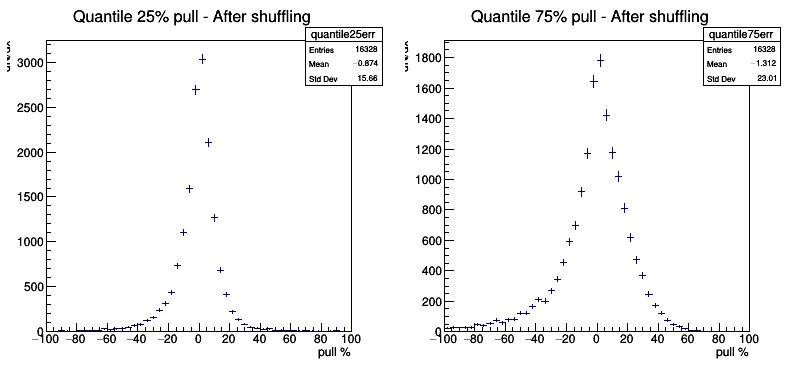

In [101]:
total_cluster_ene_gamma =[]
total_cluster_ene_nongamma = []

total_tc_energy_gamma = ROOT.TH1F("total_tc_energy_gamma","total_tc_energy_gamma",50,0,10)
total_tc_energy_nongamma = ROOT.TH1F("total_tc_energy_nongamma","total_tc_energy_nongamma",50,0,10)


for i in total_cluster_vect:
  if len(total_cluster_vect[i])>3:
    for j in total_cluster_vect[i][2]:
        total_tc_energy_gamma.Fill(j)
        total_cluster_ene_gamma.append(j)
  else:
    for j in total_cluster_vect[i][2]:
        total_tc_energy_nongamma.Fill(j)
        total_cluster_ene_nongamma.append(j)
    
gamma25 = np.percentile(total_cluster_ene_gamma,25)
gamma75 =np.percentile(total_cluster_ene_gamma,75)
bg25 = np.percentile(total_cluster_ene_nongamma,25)
bg75 = np.percentile(total_cluster_ene_nongamma,75)
gammaMean = np.mean(total_cluster_ene_gamma)
bgMean = np.mean(total_cluster_ene_nongamma)
print(gammaMean,gamma25,gamma75,math.log(4/3)/gammaMean,math.log(4)/gammaMean)
print(bgMean,bg25,bg75,math.log(4/3)/bgMean,math.log(4)/bgMean)

      
quantile25err = ROOT.TH1F("quantile25err","quantile25err",50,-100,100)
quantile25errRand = ROOT.TH1F("quantile25err","quantile25err",50,-100,100)
quantile25errVsN = ROOT.TH2F("quantile25errVsN","quantile25errVsN",50,-100,100,50,0,300)
quantile75err = ROOT.TH1F("quantile75err","quantile75err",50,-100,100)
quantile75errRand = ROOT.TH1F("quantile75err","quantile75err",50,-100,100)
quantile75errVsN = ROOT.TH2F("quantile75errVsN","quantile75errVsN",50,-100,100,50,0,300)

for idx in total_cluster_vect:
    quantile25err.Fill(total_cluster_vect[idx][1][0])
    np.random.shuffle(total_cluster_vect[idx][2])
    percentili = calc_percentile(total_cluster_vect[idx][2])
    quantile25errRand.Fill(percentili[0])
    quantile75errRand.Fill(percentili[1])
    quantile75err.Fill(total_cluster_vect[idx][1][1])
    quantile25errVsN.Fill(total_cluster_vect[idx][1][0],len(total_cluster_vect[idx][2]))
    quantile75errVsN.Fill(total_cluster_vect[idx][1][1],len(total_cluster_vect[idx][2]))


canvas2 = ROOT.TCanvas("canvas2","canvas2",800,400)
canvas2.Divide(2)
canvas2.cd(1)
quantile25err.SetTitle("Quantile 25% pull")
quantile25err.GetYaxis().SetTitle("dN/dx")
quantile25err.GetXaxis().SetTitle("pull %")
quantile25err.Draw("ER")
canvas2.cd(2)
quantile75err.GetYaxis().SetTitle("dN/dx")
quantile75err.GetXaxis().SetTitle("pull %")
quantile75err.SetTitle("Quantile 75% pull")
quantile75err.Draw("ER")
canvas2.Draw()

canvas2b = ROOT.TCanvas("canvas2b","canvas2b",800,400)
canvas2b.Divide(2)
canvas2b.cd(1)
quantile25errVsN.SetTitle("Quantile 25% pull Vs Number of TCs")
quantile25errVsN.GetYaxis().SetTitle("Number of TCs")
quantile25errVsN.GetXaxis().SetTitle("pull %")
quantile25errVsN.Draw("CONT4")
canvas2b.cd(2)
quantile75errVsN.GetYaxis().SetTitle("Number of TCs")
quantile75errVsN.GetXaxis().SetTitle("pull %")
quantile75errVsN.SetTitle("Quantile 75% pull Vs Number of TCs")
quantile75errVsN.Draw("CONT4")
canvas2b.Draw()

canvas3 = ROOT.TCanvas("canvas3","canvas3",800,800)
ROOT.gPad.SetLogy()
total_tc_energy_gamma.GetYaxis().SetTitle("a.u.")
total_tc_energy_gamma.GetXaxis().SetTitle("Energy [GeV]")
total_tc_energy_gamma.SetTitle("TC energy")
total_tc_energy_gamma.SetLineColor(2)
total_tc_energy_gamma.DrawNormalized("ER")
total_tc_energy_nongamma.GetYaxis().SetTitle("a.u.")
total_tc_energy_nongamma.GetXaxis().SetTitle("Energy [GeV]")
total_tc_energy_nongamma.SetTitle("TC energy")
total_tc_energy_nongamma.DrawNormalized("ER SAME")
legend = ROOT.TLegend(0.4,0.7,0.6,0.9);
legend.AddEntry(total_tc_energy_gamma,"HE gammas","l");
legend.AddEntry(total_tc_energy_nongamma,"Other clusters","l");
legend.Draw();
gamma25_line=ROOT.TLine(gamma25,0,gamma25,total_tc_energy_nongamma.GetYaxis().GetXmax()*0.6)
gamma25_line.SetLineColor(2)
gamma25_line.Draw("same")
gamma75_line=ROOT.TLine(gamma75,0,gamma75,total_tc_energy_nongamma.GetYaxis().GetXmax()*0.6)
gamma75_line.SetLineColor(2)
gamma75_line.Draw("same")
bg25_line=ROOT.TLine(bg25,0,bg25,total_tc_energy_nongamma.GetYaxis().GetXmax()*0.6)
bg25_line.SetLineColor(4)
bg25_line.Draw("same")
bg75_line=ROOT.TLine(bg75,0,bg75,total_tc_energy_nongamma.GetYaxis().GetXmax()*0.6)
bg75_line.SetLineColor(4)
bg75_line.Draw("same")
canvas3.Draw()
                           
canvas4 = ROOT.TCanvas("canvas4","canvas4",800,400)
canvas4.Divide(2)
canvas4.cd(1)
quantile25errRand.SetTitle("Quantile 25% pull - After shuffling")
quantile25errRand.GetYaxis().SetTitle("dN/dx")
quantile25errRand.GetXaxis().SetTitle("pull %")
quantile25errRand.Draw("ER")
canvas4.cd(2)
quantile75errRand.GetYaxis().SetTitle("dN/dx")
quantile75errRand.GetXaxis().SetTitle("pull %")
quantile75errRand.SetTitle("Quantile 75% pull - After shuffling")
quantile75errRand.Draw("ER")
canvas4.Draw()
                           